In [5]:
!pip install keras-tuner

     |████████████████████████████████| 133 kB 28.0 MB/s 


In [6]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, AveragePooling1D , Flatten, Input
from sklearn.model_selection import train_test_split
import pprint as pp
import keras_tuner as kt
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle
plt.rcParams["font.family"] = "Times New Roman"
plt.rc('font', size=12) 

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


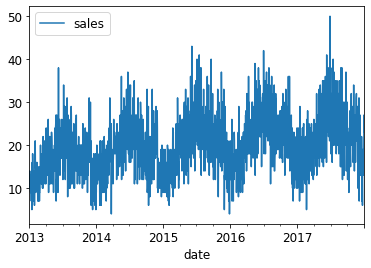

In [8]:
df = pd.read_excel("/content/drive/MyDrive/dataset.xlsx")
df.plot(x = 'date', y = 'sales')
plt.show()

In [9]:
raw_seq = df['sales']

In [10]:
train_seq = raw_seq[:1095]
val_seq = raw_seq[1095:1461].reset_index(drop=True)
test_seq = raw_seq[1461:].reset_index(drop=True)

In [11]:
print(train_seq.size, val_seq.size, test_seq.size)

1095 366 365


In [12]:
# univariate data preparation
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [13]:
n_steps = 30
n_features = 1
X_train, y_train = split_sequence(train_seq, n_steps)
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=10)
X_test, y_test = split_sequence(test_seq, n_steps)
X_val, y_val = split_sequence(val_seq, n_steps)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [14]:
def cnn_model(hp):
  model = tf.keras.Sequential() 
  model.add(Input(shape=(30,1)))

  num_filters = hp.Int('filters_cnn_layer', min_value=16, max_value=512, step=16)
  k_size = hp.Int('kernel_size', min_value=1, max_value=3, step=1)

  model.add(Conv1D(num_filters, k_size, activation='relu'))
  if hp.Choice('pooling_', ['avg', 'max']) == 'max':
    model.add(MaxPooling1D())
  else:
    model.add(AveragePooling1D())
     
  model.add(Flatten())
  model.add(Dense(hp.Int('units_fully_connected_dense', min_value=16, max_value=512, step=16), activation='relu'))
  model.add(Dense(1, activation='linear'))

  model.compile(optimizer="adam", loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

  return model

In [ ]:
tuner = kt.tuners.Hyperband(
    cnn_model,
    objective='val_mean_squared_error',
    max_epochs=30,
    hyperband_iterations=5,
    directory='cnn_exp',
    project_name='demand forecasting')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
filters_cnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
pooling_ (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max'], 'ordered': False}
units_fully_connected_dense (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
tuner.search(X_train_shuffled, y_train_shuffled, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 81 Complete [00h 00m 17s]
val_mean_squared_error: 25.675952911376953

Best val_mean_squared_error So Far: 25.016395568847656
Total elapsed time: 00h 08m 02s

Search: Running Trial #82

Value             |Best Value So Far |Hyperparameter
336               |384               |filters_cnn_layer
3                 |3                 |kernel_size
avg               |avg               |pooling_
384               |176               |units_fully_connected_dense
10                |30                |tuner/epochs
0                 |10                |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/10
34/34 [==============================] - 2s 40ms/step - loss: 50.4295 - mean_absolute_error: 5.2414 - root_mean_squared_error: 7.1014 - mean_squared_error: 50.4295 - mean_absolute_percentage_error: 32.0827 - val_loss: 28.0617 - val_mean_absolute_error: 4.2158 - val_root_mean_squared_error: 5.2973 - val_mean_squar

KeyboardInterrupt: ignored

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(30, 1))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 384)           1536      
                                                                 
 average_pooling1d (AverageP  (None, 14, 384)          0         
 ooling1D)                                                       
                                                                 
 flatten (Flatten)           (None, 5376)              0         
                                                                 
 dense (Dense)               (None, 176)               946352    
                                                                 
 dense_1 (Dense)             (None, 1)                 177       
                                                                 
Total params: 948,065
Trainable params: 948,065
Non-trainable params: 0
__________________________________________________

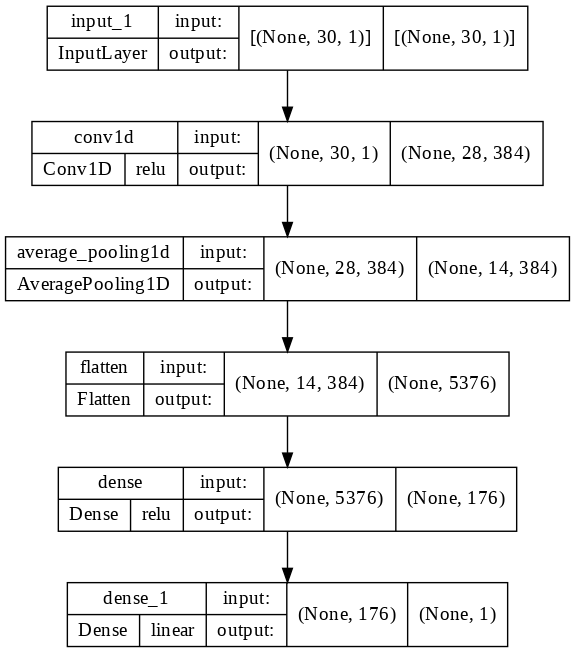

In [ ]:
plot_model(best_model, show_shapes=True, show_layer_activations=True, dpi=100)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

In [ ]:
hist =  best_model.fit(X_train, y_train, batch_size=120, epochs=2000, verbose=2, validation_data=(X_val, y_val), callbacks=[callback])

Epoch 1/2000
9/9 - 1s - loss: 21.2778 - mean_absolute_error: 3.6090 - root_mean_squared_error: 4.6128 - mean_squared_error: 21.2778 - mean_absolute_percentage_error: 22.3502 - val_loss: 25.0240 - val_mean_absolute_error: 3.9483 - val_root_mean_squared_error: 5.0024 - val_mean_squared_error: 25.0240 - val_mean_absolute_percentage_error: 20.0228 - 1s/epoch - 145ms/step
Epoch 2/2000
9/9 - 0s - loss: 21.0238 - mean_absolute_error: 3.5846 - root_mean_squared_error: 4.5852 - mean_squared_error: 21.0238 - mean_absolute_percentage_error: 22.4530 - val_loss: 25.4283 - val_mean_absolute_error: 3.9766 - val_root_mean_squared_error: 5.0426 - val_mean_squared_error: 25.4283 - val_mean_absolute_percentage_error: 20.4536 - 380ms/epoch - 42ms/step
Epoch 3/2000
9/9 - 0s - loss: 21.3000 - mean_absolute_error: 3.6291 - root_mean_squared_error: 4.6152 - mean_squared_error: 21.3000 - mean_absolute_percentage_error: 22.7694 - val_loss: 25.4298 - val_mean_absolute_error: 3.9764 - val_root_mean_squared_error:

In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'mean_squared_error', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'val_mean_squared_error', 'val_mean_absolute_percentage_error'])


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


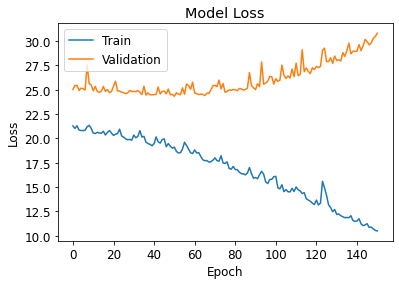

In [ ]:
# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("cnn_loss.png", dpi=300)
plt.show()

In [ ]:
best_model.evaluate(X_train, y_train, return_dict=True)

34/34 [==============================] - 0s 5ms/step - loss: 18.4890 - mean_absolute_error: 3.3815 - root_mean_squared_error: 4.2999 - mean_squared_error: 18.4890 - mean_absolute_percentage_error: 20.9909


{'loss': 18.489011764526367,
 'mean_absolute_error': 3.3814637660980225,
 'mean_absolute_percentage_error': 20.99089241027832,
 'mean_squared_error': 18.489011764526367,
 'root_mean_squared_error': 4.299885272979736}

In [ ]:
best_model.evaluate(X_val, y_val, return_dict=True)

11/11 [==============================] - 0s 6ms/step - loss: 24.3212 - mean_absolute_error: 3.8379 - root_mean_squared_error: 4.9317 - mean_squared_error: 24.3212 - mean_absolute_percentage_error: 19.0277


{'loss': 24.321203231811523,
 'mean_absolute_error': 3.83793306350708,
 'mean_absolute_percentage_error': 19.02768325805664,
 'mean_squared_error': 24.321203231811523,
 'root_mean_squared_error': 4.931653022766113}

In [ ]:
score = best_model.evaluate(X_test, y_test, return_dict=True)
y_pred = best_model.predict(X_test)
print(score)

11/11 [==============================] - 0s 5ms/step - loss: 28.4932 - mean_absolute_error: 4.2869 - root_mean_squared_error: 5.3379 - mean_squared_error: 28.4932 - mean_absolute_percentage_error: 21.0818
{'loss': 28.493247985839844, 'mean_absolute_error': 4.286914348602295, 'root_mean_squared_error': 5.337906837463379, 'mean_squared_error': 28.493247985839844, 'mean_absolute_percentage_error': 21.08184814453125}


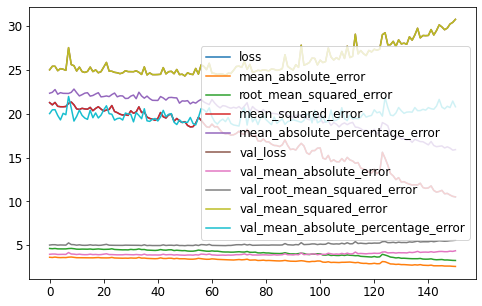

In [ ]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.show()

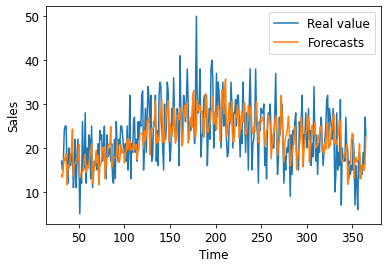

In [ ]:
dates = np.array(range(31, 366))
plt.plot(dates, y_test, label='Real value')
plt.plot(dates, y_pred, label='Forecasts')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.savefig("cnn_forecast.png", dpi=500)
plt.show()

In [ ]:
from scipy import stats
stats.ttest_ind(y_pred, y_test)

Ttest_indResult(statistic=array([-0.876106], dtype=float32), pvalue=array([0.38128733]))

In [ ]:
best_model.save('cnn.h5')